In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import einops
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass
from typing import Optional

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

@dataclass
class Config:
    n_features: int
    n_hidden: int
    n_instances: int  # Number of model instances (set to 1 for simplicity)

# Define the model class with optional non-linear hidden layers and deeper networks
class Model(nn.Module):
    def __init__(self, 
                  config, 
                  feature_probability: Optional[torch.Tensor] = None,
                  importance: Optional[torch.Tensor] = None,               
                  device=DEVICE,
                  nonlinear_hidden=False,
                  num_layers=1):
        super().__init__()
        self.config = config
        self.nonlinear_hidden = nonlinear_hidden
        self.num_layers = num_layers

        layers = []
        input_size = config.n_features
        for i in range(num_layers):
            hidden_size = config.n_hidden
            layer = nn.Linear(input_size, hidden_size)
            nn.init.xavier_normal_(layer.weight)
            layers.append(layer)
            if nonlinear_hidden:
                layers.append(nn.ReLU())
            input_size = hidden_size

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Linear(config.n_hidden, config.n_features)
        nn.init.xavier_normal_(self.decoder.weight)
        self.b_final = nn.Parameter(torch.zeros((config.n_features,), device=device))

        if feature_probability is None:
            feature_probability = torch.ones((config.n_features,), device=device)
        self.feature_probability = feature_probability.to(device)
        if importance is None:
            importance = torch.ones((config.n_features,), device=device)
        self.importance = importance.to(device)

    def forward(self, features):
        # features: [batch_size, n_features]
        hidden = features
        hidden = self.encoder(hidden)
        out = self.decoder(hidden)
        out = out + self.b_final
        out = F.relu(out)
        return out

    def generate_batch(self, n_batch, correlated=False, correlation_matrix=None):
        if not correlated:
            feat = torch.rand((n_batch, self.config.n_features), device=self.b_final.device)
        else:
            # Generate correlated features
            mean = torch.zeros(self.config.n_features, device=self.b_final.device)
            feat = torch.distributions.MultivariateNormal(mean, correlation_matrix).sample((n_batch,))
            feat = torch.sigmoid(feat)  # Map to (0,1)
        batch = torch.where(
            torch.rand((n_batch, self.config.n_features), device=self.b_final.device) <= self.feature_probability,
            feat,
            torch.zeros_like(feat, device=self.b_final.device),
        )
        return batch

In [5]:
def optimize(model, 
              n_batch=1024,
              steps=5000,
              print_freq=500,
              lr=1e-3,
              l1_lambda=0.0,
              l2_lambda=0.0):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    for step in trange(steps):
        opt.zero_grad(set_to_none=True)
        batch = model.generate_batch(n_batch)
        out = model(batch)
        error = (model.importance * (batch - out) ** 2)
        loss = error.mean()
        # Add L1 and L2 regularization if needed
        l1_norm = sum(torch.abs(param).sum() for param in model.parameters())
        l2_norm = sum(torch.norm(param) ** 2 for param in model.parameters())
        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
        loss.backward()
        opt.step()
        if step % print_freq == 0 or step == steps - 1:
            print(f"Step {step}/{steps}, Loss: {loss.item():.6f}")

# Function to measure superposition
def measure_superposition(model):
    W = model.encoder[0].weight.detach()  # Assuming the first layer is the main encoder
    norms = torch.linalg.norm(W, dim=-1, keepdim=True)  # [n_hidden, 1]
    W_normalized = W / (norms + 1e-6)
    interference = torch.abs(torch.matmul(W_normalized.T, W_normalized))
    interference = interference - torch.diag(torch.diag(interference))  # Remove self-interference
    avg_interference = interference.mean().item()
    return avg_interference

In [6]:
def fgsm_attack(model, data, epsilon, importance):
    data.requires_grad = True
    output = model(data)
    loss = (importance * (data - output) ** 2).mean()
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    # Generate adversarial examples
    perturbed_data = data + epsilon * data_grad.sign()
    # Clip data to valid range
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

def pgd_attack(model, data, epsilon, alpha, num_iter, importance):
    original_data = data.clone().detach()
    perturbed_data = data.clone().detach()
    for i in range(num_iter):
        perturbed_data.requires_grad = True
        output = model(perturbed_data)
        loss = (importance * (original_data - output) ** 2).mean()
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_data.grad.data
        perturbed_data = perturbed_data + alpha * data_grad.sign()
        # Project back into the epsilon-ball
        perturbed_data = torch.max(torch.min(perturbed_data, original_data + epsilon), original_data - epsilon)
        # Clip data to valid range
        perturbed_data = torch.clamp(perturbed_data, 0, 1).detach()
    return perturbed_data

In [7]:
def evaluate_adversarial(model, importance, epsilon=0.1, n_batch=1024, attack_type='fgsm', correlated=False, correlation_matrix=None):
    data = model.generate_batch(n_batch, correlated=correlated, correlation_matrix=correlation_matrix)
    if attack_type == 'fgsm':
        adv_data = fgsm_attack(model, data, epsilon, importance)
    elif attack_type == 'pgd':
        alpha = epsilon / 4  # Step size
        num_iter = 10  # Number of iterations
        adv_data = pgd_attack(model, data, epsilon, alpha, num_iter, importance)
    else:
        raise ValueError("Unsupported attack type")
    output = model(adv_data)
    loss = (importance * (data - output) ** 2).mean()
    return loss.item()


In [8]:
def run_experiment(n_features=100, n_hidden_list=[20, 40, 60, 80, 100, 120], l1_lambda_list=[0.0], l2_lambda_list=[0.0], attack_type='fgsm', nonlinear_hidden=False, num_layers=1, feature_probability=0.5, correlated=False, correlation_matrix=None):
    results = []
    for l1_lambda in l1_lambda_list:
        for l2_lambda in l2_lambda_list:
            for n_hidden in n_hidden_list:
                print(f"\nTraining model with n_hidden = {n_hidden}, l1_lambda = {l1_lambda}, l2_lambda = {l2_lambda}")
                config = Config(
                    n_features=n_features,
                    n_hidden=n_hidden,
                    n_instances=1,
                )
                feature_prob_tensor = torch.ones((n_features,), device=DEVICE) * feature_probability
                importance = torch.ones((n_features,), device=DEVICE)
                model = Model(
                    config=config,
                    device=DEVICE,
                    feature_probability=feature_prob_tensor,
                    importance=importance,
                    nonlinear_hidden=nonlinear_hidden,
                    num_layers=num_layers
                )
                optimize(model, steps=5000, lr=1e-3, l1_lambda=l1_lambda, l2_lambda=l2_lambda)
                loss_clean = evaluate_adversarial(model, importance, epsilon=0.0, attack_type=attack_type, correlated=correlated, correlation_matrix=correlation_matrix)
                loss_adv = evaluate_adversarial(model, importance, epsilon=0.1, attack_type=attack_type, correlated=correlated, correlation_matrix=correlation_matrix)
                superposition_measure = measure_superposition(model)
                results.append({
                    'n_hidden': n_hidden,
                    'l1_lambda': l1_lambda,
                    'l2_lambda': l2_lambda,
                    'loss_clean': loss_clean,
                    'loss_adv': loss_adv,
                    'superposition': superposition_measure,
                    'attack_type': attack_type,
                    'nonlinear_hidden': nonlinear_hidden,
                    'num_layers': num_layers,
                    'feature_probability': feature_probability,
                    'correlated': correlated
                })
    return results

In [13]:
def plot_weight_histogram(model, title='Weight Histogram'):
    weights = model.encoder[0].weight.detach().cpu().numpy().flatten()
    plt.figure(figsize=(8, 6))
    plt.hist(weights, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()

In [9]:
def plot_activation_patterns(model, data, title='Activation Patterns'):
    with torch.no_grad():
        if model.nonlinear_hidden:
            activations = model.encoder(data)
        else:
            activations = F.relu(model.encoder(data))
        activations = activations.cpu().numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(activations, cmap='viridis')
    plt.title(title)
    plt.xlabel('Neurons')
    plt.ylabel('Samples')
    plt.show()

In [10]:
def create_correlation_matrix(n_features, correlation_coefficient):
    corr_matrix = torch.eye(n_features) * (1 - correlation_coefficient) + correlation_coefficient
    return corr_matrix

In [11]:
n_features = 100
n_hidden_list = [20, 40, 60, 80, 100, 120]
l1_lambda_list = [0.0, 5e-4, 1e-3]
l2_lambda_list = [0.0, 1e-4, 5e-4]
results_regularization = run_experiment(
    n_features=n_features,
    n_hidden_list=n_hidden_list,
    l1_lambda_list=l1_lambda_list,
    l2_lambda_list=l2_lambda_list,
    attack_type='pgd',
    nonlinear_hidden=False,
    num_layers=1,
    feature_probability=0.5,
    correlated=False
)


Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.155499
Step 500/5000, Loss: 0.083107
Step 1000/5000, Loss: 0.082376
Step 1500/5000, Loss: 0.082390
Step 2000/5000, Loss: 0.080856
Step 2500/5000, Loss: 0.079889
Step 3000/5000, Loss: 0.078606
Step 3500/5000, Loss: 0.077701
Step 4000/5000, Loss: 0.077947
Step 4500/5000, Loss: 0.077719
Step 4999/5000, Loss: 0.077510

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.164518
Step 500/5000, Loss: 0.058835
Step 1000/5000, Loss: 0.058702
Step 1500/5000, Loss: 0.058304
Step 2000/5000, Loss: 0.055481
Step 2500/5000, Loss: 0.053160
Step 3000/5000, Loss: 0.051858
Step 3500/5000, Loss: 0.050996
Step 4000/5000, Loss: 0.051012
Step 4500/5000, Loss: 0.051007
Step 4999/5000, Loss: 0.051005

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.164646
Step 500/5000, Loss: 0.036342
Step 1000/5000, Loss: 0.035874
Step 1500/5000, Loss: 0.033461
Step 2000/5000, Loss: 0.031861
Step 2500/5000, Loss: 0.030518
Step 3000/5000, Loss: 0.029897
Step 3500/5000, Loss: 0.030266
Step 4000/5000, Loss: 0.030039
Step 4500/5000, Loss: 0.030733
Step 4999/5000, Loss: 0.029674

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.168827
Step 500/5000, Loss: 0.016611
Step 1000/5000, Loss: 0.015945
Step 1500/5000, Loss: 0.015680
Step 2000/5000, Loss: 0.015660
Step 2500/5000, Loss: 0.015107
Step 3000/5000, Loss: 0.015300
Step 3500/5000, Loss: 0.015412
Step 4000/5000, Loss: 0.015259
Step 4500/5000, Loss: 0.015080
Step 4999/5000, Loss: 0.014906

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.179283
Step 500/5000, Loss: 0.000098
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000031
Step 4000/5000, Loss: 0.000001
Step 4500/5000, Loss: 0.000002
Step 4999/5000, Loss: 0.000017

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.166431
Step 500/5000, Loss: 0.000003
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000001
Step 3000/5000, Loss: 0.000010
Step 3500/5000, Loss: 0.000001
Step 4000/5000, Loss: 0.000001
Step 4500/5000, Loss: 0.000015
Step 4999/5000, Loss: 0.000000

Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.160342
Step 500/5000, Loss: 0.087344
Step 1000/5000, Loss: 0.086673
Step 1500/5000, Loss: 0.086665
Step 2000/5000, Loss: 0.086574
Step 2500/5000, Loss: 0.086338
Step 3000/5000, Loss: 0.085981
Step 3500/5000, Loss: 0.084977
Step 4000/5000, Loss: 0.084825
Step 4500/5000, Loss: 0.084394
Step 4999/5000, Loss: 0.084549

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.172792
Step 500/5000, Loss: 0.069620
Step 1000/5000, Loss: 0.068502
Step 1500/5000, Loss: 0.068372
Step 2000/5000, Loss: 0.068266
Step 2500/5000, Loss: 0.067338
Step 3000/5000, Loss: 0.065162
Step 3500/5000, Loss: 0.065868
Step 4000/5000, Loss: 0.065359
Step 4500/5000, Loss: 0.065169
Step 4999/5000, Loss: 0.064983

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.178179
Step 500/5000, Loss: 0.050776
Step 1000/5000, Loss: 0.050859
Step 1500/5000, Loss: 0.050119
Step 2000/5000, Loss: 0.048732
Step 2500/5000, Loss: 0.048427
Step 3000/5000, Loss: 0.048354
Step 3500/5000, Loss: 0.047622
Step 4000/5000, Loss: 0.047785
Step 4500/5000, Loss: 0.047682
Step 4999/5000, Loss: 0.047720

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.193687
Step 500/5000, Loss: 0.034555
Step 1000/5000, Loss: 0.033677
Step 1500/5000, Loss: 0.033929
Step 2000/5000, Loss: 0.033575
Step 2500/5000, Loss: 0.033475
Step 3000/5000, Loss: 0.033438
Step 3500/5000, Loss: 0.033342
Step 4000/5000, Loss: 0.032980
Step 4500/5000, Loss: 0.033542
Step 4999/5000, Loss: 0.033462

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.192754
Step 500/5000, Loss: 0.019598
Step 1000/5000, Loss: 0.019063
Step 1500/5000, Loss: 0.019045
Step 2000/5000, Loss: 0.019055
Step 2500/5000, Loss: 0.019052
Step 3000/5000, Loss: 0.019067
Step 3500/5000, Loss: 0.019066
Step 4000/5000, Loss: 0.019063
Step 4500/5000, Loss: 0.019063
Step 4999/5000, Loss: 0.019069

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.191718
Step 500/5000, Loss: 0.019249
Step 1000/5000, Loss: 0.019053
Step 1500/5000, Loss: 0.019053
Step 2000/5000, Loss: 0.019059
Step 2500/5000, Loss: 0.019055
Step 3000/5000, Loss: 0.019063
Step 3500/5000, Loss: 0.019066
Step 4000/5000, Loss: 0.019065
Step 4500/5000, Loss: 0.019069
Step 4999/5000, Loss: 0.019060

Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.194363
Step 500/5000, Loss: 0.098981
Step 1000/5000, Loss: 0.098540
Step 1500/5000, Loss: 0.097983
Step 2000/5000, Loss: 0.098661
Step 2500/5000, Loss: 0.098758
Step 3000/5000, Loss: 0.098803
Step 3500/5000, Loss: 0.098466
Step 4000/5000, Loss: 0.098190
Step 4500/5000, Loss: 0.098405
Step 4999/5000, Loss: 0.099172

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.216899
Step 500/5000, Loss: 0.093414
Step 1000/5000, Loss: 0.093117
Step 1500/5000, Loss: 0.093410
Step 2000/5000, Loss: 0.092999
Step 2500/5000, Loss: 0.093013
Step 3000/5000, Loss: 0.093263
Step 3500/5000, Loss: 0.092937
Step 4000/5000, Loss: 0.092386
Step 4500/5000, Loss: 0.093133
Step 4999/5000, Loss: 0.092982

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.241821
Step 500/5000, Loss: 0.087209
Step 1000/5000, Loss: 0.087329
Step 1500/5000, Loss: 0.087615
Step 2000/5000, Loss: 0.087249
Step 2500/5000, Loss: 0.086926
Step 3000/5000, Loss: 0.087365
Step 3500/5000, Loss: 0.087841
Step 4000/5000, Loss: 0.087572
Step 4500/5000, Loss: 0.087468
Step 4999/5000, Loss: 0.087674

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.261283
Step 500/5000, Loss: 0.081896
Step 1000/5000, Loss: 0.081593
Step 1500/5000, Loss: 0.081753
Step 2000/5000, Loss: 0.082028
Step 2500/5000, Loss: 0.081856
Step 3000/5000, Loss: 0.081789
Step 3500/5000, Loss: 0.081909
Step 4000/5000, Loss: 0.081834
Step 4500/5000, Loss: 0.081570
Step 4999/5000, Loss: 0.082178

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.274698
Step 500/5000, Loss: 0.076390
Step 1000/5000, Loss: 0.076031
Step 1500/5000, Loss: 0.076124
Step 2000/5000, Loss: 0.076137
Step 2500/5000, Loss: 0.076301
Step 3000/5000, Loss: 0.076172
Step 3500/5000, Loss: 0.076233
Step 4000/5000, Loss: 0.076143
Step 4500/5000, Loss: 0.076398
Step 4999/5000, Loss: 0.076241

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.285337
Step 500/5000, Loss: 0.076297
Step 1000/5000, Loss: 0.076165
Step 1500/5000, Loss: 0.076147
Step 2000/5000, Loss: 0.076253
Step 2500/5000, Loss: 0.076130
Step 3000/5000, Loss: 0.076391
Step 3500/5000, Loss: 0.076241
Step 4000/5000, Loss: 0.076187
Step 4500/5000, Loss: 0.076200
Step 4999/5000, Loss: 0.076169

Training model with n_hidden = 20, l1_lambda = 0.0005, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.372368
Step 500/5000, Loss: 0.116162
Step 1000/5000, Loss: 0.111729
Step 1500/5000, Loss: 0.111208
Step 2000/5000, Loss: 0.110785
Step 2500/5000, Loss: 0.109856
Step 3000/5000, Loss: 0.110011
Step 3500/5000, Loss: 0.109558
Step 4000/5000, Loss: 0.109505
Step 4500/5000, Loss: 0.108921
Step 4999/5000, Loss: 0.109067

Training model with n_hidden = 40, l1_lambda = 0.0005, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.557406
Step 500/5000, Loss: 0.113295
Step 1000/5000, Loss: 0.111236
Step 1500/5000, Loss: 0.110860
Step 2000/5000, Loss: 0.110689
Step 2500/5000, Loss: 0.109957
Step 3000/5000, Loss: 0.109938
Step 3500/5000, Loss: 0.109679
Step 4000/5000, Loss: 0.109359
Step 4500/5000, Loss: 0.108671
Step 4999/5000, Loss: 0.109028

Training model with n_hidden = 60, l1_lambda = 0.0005, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.706049
Step 500/5000, Loss: 0.114327
Step 1000/5000, Loss: 0.112868
Step 1500/5000, Loss: 0.111189
Step 2000/5000, Loss: 0.111099
Step 2500/5000, Loss: 0.110863
Step 3000/5000, Loss: 0.110606
Step 3500/5000, Loss: 0.110423
Step 4000/5000, Loss: 0.110165
Step 4500/5000, Loss: 0.109996
Step 4999/5000, Loss: 0.108897

Training model with n_hidden = 80, l1_lambda = 0.0005, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.850663
Step 500/5000, Loss: 0.118061
Step 1000/5000, Loss: 0.116467
Step 1500/5000, Loss: 0.116205
Step 2000/5000, Loss: 0.116371
Step 2500/5000, Loss: 0.116480
Step 3000/5000, Loss: 0.116384
Step 3500/5000, Loss: 0.116292
Step 4000/5000, Loss: 0.116166
Step 4500/5000, Loss: 0.116682
Step 4999/5000, Loss: 0.116615

Training model with n_hidden = 100, l1_lambda = 0.0005, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.975080
Step 500/5000, Loss: 0.114703
Step 1000/5000, Loss: 0.112260
Step 1500/5000, Loss: 0.111933
Step 2000/5000, Loss: 0.111482
Step 2500/5000, Loss: 0.110800
Step 3000/5000, Loss: 0.109869
Step 3500/5000, Loss: 0.110248
Step 4000/5000, Loss: 0.109662
Step 4500/5000, Loss: 0.109632
Step 4999/5000, Loss: 0.109969

Training model with n_hidden = 120, l1_lambda = 0.0005, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.091073
Step 500/5000, Loss: 0.115802
Step 1000/5000, Loss: 0.113327
Step 1500/5000, Loss: 0.112744
Step 2000/5000, Loss: 0.111432
Step 2500/5000, Loss: 0.110624
Step 3000/5000, Loss: 0.110801
Step 3500/5000, Loss: 0.110631
Step 4000/5000, Loss: 0.110249
Step 4500/5000, Loss: 0.109796
Step 4999/5000, Loss: 0.111015

Training model with n_hidden = 20, l1_lambda = 0.0005, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.371827
Step 500/5000, Loss: 0.116072
Step 1000/5000, Loss: 0.112114
Step 1500/5000, Loss: 0.111432
Step 2000/5000, Loss: 0.111970
Step 2500/5000, Loss: 0.111404
Step 3000/5000, Loss: 0.110601
Step 3500/5000, Loss: 0.111467
Step 4000/5000, Loss: 0.110537
Step 4500/5000, Loss: 0.110693
Step 4999/5000, Loss: 0.111653

Training model with n_hidden = 40, l1_lambda = 0.0005, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.560370
Step 500/5000, Loss: 0.113452
Step 1000/5000, Loss: 0.112118
Step 1500/5000, Loss: 0.111803
Step 2000/5000, Loss: 0.111975
Step 2500/5000, Loss: 0.111948
Step 3000/5000, Loss: 0.111722
Step 3500/5000, Loss: 0.110513
Step 4000/5000, Loss: 0.111124
Step 4500/5000, Loss: 0.111215
Step 4999/5000, Loss: 0.111601

Training model with n_hidden = 60, l1_lambda = 0.0005, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.727985
Step 500/5000, Loss: 0.118769
Step 1000/5000, Loss: 0.112428
Step 1500/5000, Loss: 0.112515
Step 2000/5000, Loss: 0.111222
Step 2500/5000, Loss: 0.111803
Step 3000/5000, Loss: 0.112526
Step 3500/5000, Loss: 0.110724
Step 4000/5000, Loss: 0.111377
Step 4500/5000, Loss: 0.111282
Step 4999/5000, Loss: 0.111196

Training model with n_hidden = 80, l1_lambda = 0.0005, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.865115
Step 500/5000, Loss: 0.114630
Step 1000/5000, Loss: 0.113308
Step 1500/5000, Loss: 0.112588
Step 2000/5000, Loss: 0.112249
Step 2500/5000, Loss: 0.111466
Step 3000/5000, Loss: 0.111816
Step 3500/5000, Loss: 0.111548
Step 4000/5000, Loss: 0.110827
Step 4500/5000, Loss: 0.111207
Step 4999/5000, Loss: 0.111537

Training model with n_hidden = 100, l1_lambda = 0.0005, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.994953
Step 500/5000, Loss: 0.118483
Step 1000/5000, Loss: 0.117212
Step 1500/5000, Loss: 0.117119
Step 2000/5000, Loss: 0.117195
Step 2500/5000, Loss: 0.117676
Step 3000/5000, Loss: 0.117630
Step 3500/5000, Loss: 0.116993
Step 4000/5000, Loss: 0.116730
Step 4500/5000, Loss: 0.117914
Step 4999/5000, Loss: 0.117369

Training model with n_hidden = 120, l1_lambda = 0.0005, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.110222
Step 500/5000, Loss: 0.114642
Step 1000/5000, Loss: 0.113880
Step 1500/5000, Loss: 0.113317
Step 2000/5000, Loss: 0.112872
Step 2500/5000, Loss: 0.112383
Step 3000/5000, Loss: 0.111969
Step 3500/5000, Loss: 0.111653
Step 4000/5000, Loss: 0.112234
Step 4500/5000, Loss: 0.112191
Step 4999/5000, Loss: 0.112286

Training model with n_hidden = 20, l1_lambda = 0.0005, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.400086
Step 500/5000, Loss: 0.113938
Step 1000/5000, Loss: 0.113050
Step 1500/5000, Loss: 0.113227
Step 2000/5000, Loss: 0.112735
Step 2500/5000, Loss: 0.113738
Step 3000/5000, Loss: 0.112479
Step 3500/5000, Loss: 0.112639
Step 4000/5000, Loss: 0.113711
Step 4500/5000, Loss: 0.112747
Step 4999/5000, Loss: 0.113290

Training model with n_hidden = 40, l1_lambda = 0.0005, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.604490
Step 500/5000, Loss: 0.114024
Step 1000/5000, Loss: 0.113472
Step 1500/5000, Loss: 0.113648
Step 2000/5000, Loss: 0.113329
Step 2500/5000, Loss: 0.113746
Step 3000/5000, Loss: 0.113397
Step 3500/5000, Loss: 0.113540
Step 4000/5000, Loss: 0.113628
Step 4500/5000, Loss: 0.113516
Step 4999/5000, Loss: 0.113389

Training model with n_hidden = 60, l1_lambda = 0.0005, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.764787
Step 500/5000, Loss: 0.113636
Step 1000/5000, Loss: 0.113145
Step 1500/5000, Loss: 0.112482
Step 2000/5000, Loss: 0.113379
Step 2500/5000, Loss: 0.113206
Step 3000/5000, Loss: 0.113177
Step 3500/5000, Loss: 0.113728
Step 4000/5000, Loss: 0.113307
Step 4500/5000, Loss: 0.113016
Step 4999/5000, Loss: 0.113322

Training model with n_hidden = 80, l1_lambda = 0.0005, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.924299
Step 500/5000, Loss: 0.114444
Step 1000/5000, Loss: 0.113806
Step 1500/5000, Loss: 0.113777
Step 2000/5000, Loss: 0.113273
Step 2500/5000, Loss: 0.114059
Step 3000/5000, Loss: 0.113608
Step 3500/5000, Loss: 0.114107
Step 4000/5000, Loss: 0.114041
Step 4500/5000, Loss: 0.113555
Step 4999/5000, Loss: 0.113578

Training model with n_hidden = 100, l1_lambda = 0.0005, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.061871
Step 500/5000, Loss: 0.118753
Step 1000/5000, Loss: 0.114144
Step 1500/5000, Loss: 0.113868
Step 2000/5000, Loss: 0.113935
Step 2500/5000, Loss: 0.114415
Step 3000/5000, Loss: 0.114141
Step 3500/5000, Loss: 0.114267
Step 4000/5000, Loss: 0.114178
Step 4500/5000, Loss: 0.113356
Step 4999/5000, Loss: 0.113246

Training model with n_hidden = 120, l1_lambda = 0.0005, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.186762
Step 500/5000, Loss: 0.115162
Step 1000/5000, Loss: 0.114741
Step 1500/5000, Loss: 0.114663
Step 2000/5000, Loss: 0.113249
Step 2500/5000, Loss: 0.113784
Step 3000/5000, Loss: 0.114370
Step 3500/5000, Loss: 0.113288
Step 4000/5000, Loss: 0.114646
Step 4500/5000, Loss: 0.114680
Step 4999/5000, Loss: 0.114191

Training model with n_hidden = 20, l1_lambda = 0.001, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.576527
Step 500/5000, Loss: 0.127236
Step 1000/5000, Loss: 0.128120
Step 1500/5000, Loss: 0.126877
Step 2000/5000, Loss: 0.126347
Step 2500/5000, Loss: 0.127357
Step 3000/5000, Loss: 0.127543
Step 3500/5000, Loss: 0.126533
Step 4000/5000, Loss: 0.127202
Step 4500/5000, Loss: 0.127448
Step 4999/5000, Loss: 0.127151

Training model with n_hidden = 40, l1_lambda = 0.001, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.937851
Step 500/5000, Loss: 0.126860
Step 1000/5000, Loss: 0.127157
Step 1500/5000, Loss: 0.127627
Step 2000/5000, Loss: 0.128066
Step 2500/5000, Loss: 0.127254
Step 3000/5000, Loss: 0.126839
Step 3500/5000, Loss: 0.127444
Step 4000/5000, Loss: 0.126418
Step 4500/5000, Loss: 0.127906
Step 4999/5000, Loss: 0.127373

Training model with n_hidden = 60, l1_lambda = 0.001, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.228034
Step 500/5000, Loss: 0.128377
Step 1000/5000, Loss: 0.127965
Step 1500/5000, Loss: 0.128551
Step 2000/5000, Loss: 0.127669
Step 2500/5000, Loss: 0.128330
Step 3000/5000, Loss: 0.127854
Step 3500/5000, Loss: 0.127541
Step 4000/5000, Loss: 0.127303
Step 4500/5000, Loss: 0.127476
Step 4999/5000, Loss: 0.127900

Training model with n_hidden = 80, l1_lambda = 0.001, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.519473
Step 500/5000, Loss: 0.128246
Step 1000/5000, Loss: 0.127709
Step 1500/5000, Loss: 0.128349
Step 2000/5000, Loss: 0.127838
Step 2500/5000, Loss: 0.129225
Step 3000/5000, Loss: 0.128924
Step 3500/5000, Loss: 0.128685
Step 4000/5000, Loss: 0.128914
Step 4500/5000, Loss: 0.128227
Step 4999/5000, Loss: 0.127469

Training model with n_hidden = 100, l1_lambda = 0.001, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.783715
Step 500/5000, Loss: 0.128880
Step 1000/5000, Loss: 0.128305
Step 1500/5000, Loss: 0.129012
Step 2000/5000, Loss: 0.129645
Step 2500/5000, Loss: 0.129147
Step 3000/5000, Loss: 0.128678
Step 3500/5000, Loss: 0.127812
Step 4000/5000, Loss: 0.128304
Step 4500/5000, Loss: 0.129242
Step 4999/5000, Loss: 0.129400

Training model with n_hidden = 120, l1_lambda = 0.001, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 2.011745
Step 500/5000, Loss: 0.128724
Step 1000/5000, Loss: 0.129690
Step 1500/5000, Loss: 0.128772
Step 2000/5000, Loss: 0.129381
Step 2500/5000, Loss: 0.130131
Step 3000/5000, Loss: 0.128667
Step 3500/5000, Loss: 0.128993
Step 4000/5000, Loss: 0.128770
Step 4500/5000, Loss: 0.129243
Step 4999/5000, Loss: 0.129067

Training model with n_hidden = 20, l1_lambda = 0.001, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.590935
Step 500/5000, Loss: 0.126782
Step 1000/5000, Loss: 0.126789
Step 1500/5000, Loss: 0.127990
Step 2000/5000, Loss: 0.127744
Step 2500/5000, Loss: 0.127219
Step 3000/5000, Loss: 0.127583
Step 3500/5000, Loss: 0.126230
Step 4000/5000, Loss: 0.126878
Step 4500/5000, Loss: 0.127452
Step 4999/5000, Loss: 0.126589

Training model with n_hidden = 40, l1_lambda = 0.001, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.947059
Step 500/5000, Loss: 0.128425
Step 1000/5000, Loss: 0.127926
Step 1500/5000, Loss: 0.127744
Step 2000/5000, Loss: 0.127315
Step 2500/5000, Loss: 0.128047
Step 3000/5000, Loss: 0.127881
Step 3500/5000, Loss: 0.127235
Step 4000/5000, Loss: 0.128367
Step 4500/5000, Loss: 0.127872
Step 4999/5000, Loss: 0.127954

Training model with n_hidden = 60, l1_lambda = 0.001, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.260011
Step 500/5000, Loss: 0.127940
Step 1000/5000, Loss: 0.127508
Step 1500/5000, Loss: 0.128910
Step 2000/5000, Loss: 0.128387
Step 2500/5000, Loss: 0.128453
Step 3000/5000, Loss: 0.128151
Step 3500/5000, Loss: 0.128699
Step 4000/5000, Loss: 0.129029
Step 4500/5000, Loss: 0.128562
Step 4999/5000, Loss: 0.128123

Training model with n_hidden = 80, l1_lambda = 0.001, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.553691
Step 500/5000, Loss: 0.129366
Step 1000/5000, Loss: 0.128706
Step 1500/5000, Loss: 0.129369
Step 2000/5000, Loss: 0.128183
Step 2500/5000, Loss: 0.127991
Step 3000/5000, Loss: 0.128437
Step 3500/5000, Loss: 0.128884
Step 4000/5000, Loss: 0.128269
Step 4500/5000, Loss: 0.128120
Step 4999/5000, Loss: 0.128458

Training model with n_hidden = 100, l1_lambda = 0.001, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.790093
Step 500/5000, Loss: 0.129472
Step 1000/5000, Loss: 0.128673
Step 1500/5000, Loss: 0.128705
Step 2000/5000, Loss: 0.129184
Step 2500/5000, Loss: 0.129238
Step 3000/5000, Loss: 0.129564
Step 3500/5000, Loss: 0.129023
Step 4000/5000, Loss: 0.128930
Step 4500/5000, Loss: 0.130328
Step 4999/5000, Loss: 0.129561

Training model with n_hidden = 120, l1_lambda = 0.001, l2_lambda = 0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 2.038009
Step 500/5000, Loss: 0.129731
Step 1000/5000, Loss: 0.128985
Step 1500/5000, Loss: 0.129820
Step 2000/5000, Loss: 0.128820
Step 2500/5000, Loss: 0.129391
Step 3000/5000, Loss: 0.129718
Step 3500/5000, Loss: 0.128722
Step 4000/5000, Loss: 0.129892
Step 4500/5000, Loss: 0.129770
Step 4999/5000, Loss: 0.129796

Training model with n_hidden = 20, l1_lambda = 0.001, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.621862
Step 500/5000, Loss: 0.122372
Step 1000/5000, Loss: 0.121593
Step 1500/5000, Loss: 0.121529
Step 2000/5000, Loss: 0.120910
Step 2500/5000, Loss: 0.119554
Step 3000/5000, Loss: 0.120323
Step 3500/5000, Loss: 0.120095
Step 4000/5000, Loss: 0.120289
Step 4500/5000, Loss: 0.120096
Step 4999/5000, Loss: 0.119487

Training model with n_hidden = 40, l1_lambda = 0.001, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.992429
Step 500/5000, Loss: 0.122450
Step 1000/5000, Loss: 0.122044
Step 1500/5000, Loss: 0.121775
Step 2000/5000, Loss: 0.120072
Step 2500/5000, Loss: 0.120312
Step 3000/5000, Loss: 0.120795
Step 3500/5000, Loss: 0.120965
Step 4000/5000, Loss: 0.120319
Step 4500/5000, Loss: 0.120993
Step 4999/5000, Loss: 0.120363

Training model with n_hidden = 60, l1_lambda = 0.001, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.312865
Step 500/5000, Loss: 0.129823
Step 1000/5000, Loss: 0.128979
Step 1500/5000, Loss: 0.129364
Step 2000/5000, Loss: 0.128884
Step 2500/5000, Loss: 0.128746
Step 3000/5000, Loss: 0.127941
Step 3500/5000, Loss: 0.127730
Step 4000/5000, Loss: 0.128477
Step 4500/5000, Loss: 0.128250
Step 4999/5000, Loss: 0.128543

Training model with n_hidden = 80, l1_lambda = 0.001, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.635447
Step 500/5000, Loss: 0.129415
Step 1000/5000, Loss: 0.129321
Step 1500/5000, Loss: 0.129503
Step 2000/5000, Loss: 0.129314
Step 2500/5000, Loss: 0.129907
Step 3000/5000, Loss: 0.129283
Step 3500/5000, Loss: 0.129163
Step 4000/5000, Loss: 0.129725
Step 4500/5000, Loss: 0.129025
Step 4999/5000, Loss: 0.129763

Training model with n_hidden = 100, l1_lambda = 0.001, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.863039
Step 500/5000, Loss: 0.130260
Step 1000/5000, Loss: 0.129693
Step 1500/5000, Loss: 0.129514
Step 2000/5000, Loss: 0.129440
Step 2500/5000, Loss: 0.129043
Step 3000/5000, Loss: 0.129706
Step 3500/5000, Loss: 0.129688
Step 4000/5000, Loss: 0.129241
Step 4500/5000, Loss: 0.130164
Step 4999/5000, Loss: 0.130217

Training model with n_hidden = 120, l1_lambda = 0.001, l2_lambda = 0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 2.091598
Step 500/5000, Loss: 0.129712
Step 1000/5000, Loss: 0.130780
Step 1500/5000, Loss: 0.130561
Step 2000/5000, Loss: 0.129925
Step 2500/5000, Loss: 0.130231
Step 3000/5000, Loss: 0.131304
Step 3500/5000, Loss: 0.130360
Step 4000/5000, Loss: 0.130165
Step 4500/5000, Loss: 0.129490
Step 4999/5000, Loss: 0.129806


In [12]:
df_results_regularization = pd.DataFrame(results_regularization)

print("\nResults with Different Regularization Strengths:")
display(df_results_regularization)


Results with Different Regularization Strengths:


,n_hidden,l1_lambda,l2_lambda,loss_clean,loss_adv,superposition,attack_type,nonlinear_hidden,num_layers,feature_probability,correlated
0,20,0.0000,0.0000,7.793858e-02,0.086548,0.006443,pgd,False,1,0.5,False
1,40,0.0000,0.0000,5.060347e-02,0.065395,0.012713,pgd,False,1,0.5,False
2,60,0.0000,0.0000,3.008052e-02,0.047171,0.024094,pgd,False,1,0.5,False
3,80,0.0000,0.0000,1.513784e-02,0.029072,0.040365,pgd,False,1,0.5,False
4,100,0.0000,0.0000,1.129020e-05,0.009599,0.049645,pgd,False,1,0.5,False
5,120,0.0000,0.0000,8.881825e-08,0.009511,0.055766,pgd,False,1,0.5,False
6,20,0.0000,0.0001,7.909179e-02,0.087337,0.007422,pgd,False,1,0.5,False
7,40,0.0000,0.0001,5.340263e-02,0.064579,0.007742,pgd,False,1,0.5,False
8,60,0.0000,0.0001,3.262989e-02,0.044728,0.011462,pgd,False,1,0.5,False
9,80,0.0000,0.0001,1.655124e-02,0.026925,0.015748,pgd,False,1,0.5,False


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.270686
Step 500/5000, Loss: 0.034009
Step 1000/5000, Loss: 0.033395
Step 1500/5000, Loss: 0.033669
Step 2000/5000, Loss: 0.032633
Step 2500/5000, Loss: 0.032938
Step 3000/5000, Loss: 0.033347
Step 3500/5000, Loss: 0.033121
Step 4000/5000, Loss: 0.033346
Step 4500/5000, Loss: 0.033060
Step 4999/5000, Loss: 0.033197


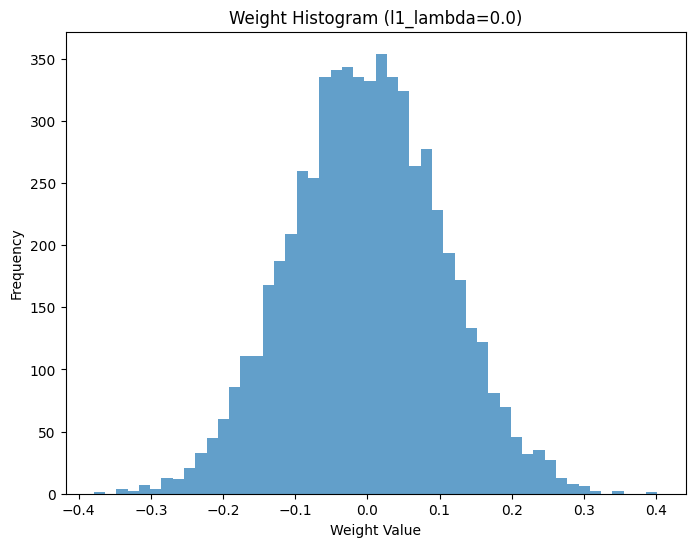

  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.813779
Step 500/5000, Loss: 0.097704
Step 1000/5000, Loss: 0.092834
Step 1500/5000, Loss: 0.092678
Step 2000/5000, Loss: 0.093028
Step 2500/5000, Loss: 0.092285
Step 3000/5000, Loss: 0.091942
Step 3500/5000, Loss: 0.091900
Step 4000/5000, Loss: 0.091964
Step 4500/5000, Loss: 0.091926
Step 4999/5000, Loss: 0.091632


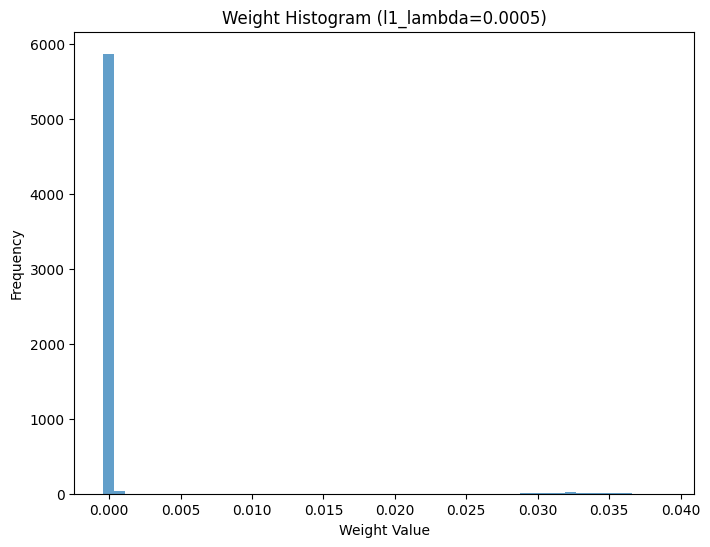

  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 1.362795
Step 500/5000, Loss: 0.104634
Step 1000/5000, Loss: 0.103002
Step 1500/5000, Loss: 0.102670
Step 2000/5000, Loss: 0.102103
Step 2500/5000, Loss: 0.102040
Step 3000/5000, Loss: 0.101702
Step 3500/5000, Loss: 0.100985
Step 4000/5000, Loss: 0.100945
Step 4500/5000, Loss: 0.100180
Step 4999/5000, Loss: 0.100040


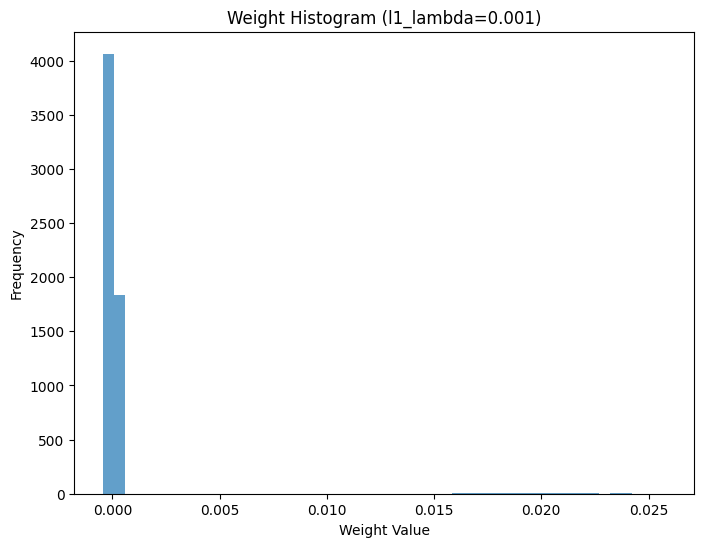

  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.257776
Step 500/5000, Loss: 0.033636
Step 1000/5000, Loss: 0.033545
Step 1500/5000, Loss: 0.033268
Step 2000/5000, Loss: 0.033348
Step 2500/5000, Loss: 0.033026
Step 3000/5000, Loss: 0.033314
Step 3500/5000, Loss: 0.033110
Step 4000/5000, Loss: 0.033121
Step 4500/5000, Loss: 0.033221
Step 4999/5000, Loss: 0.033506


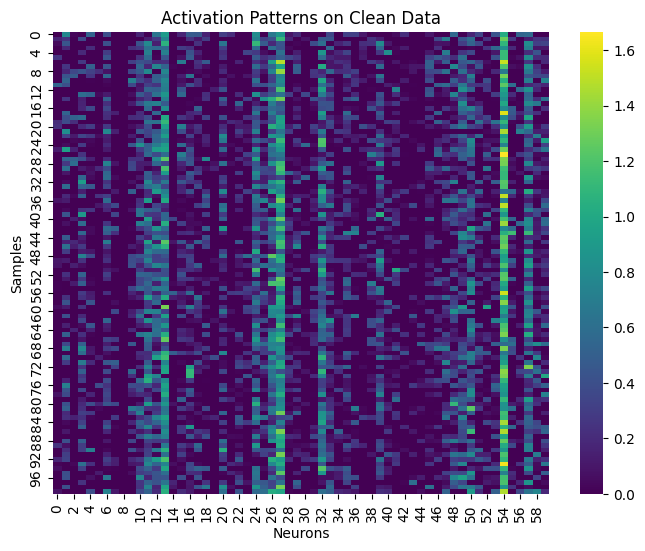

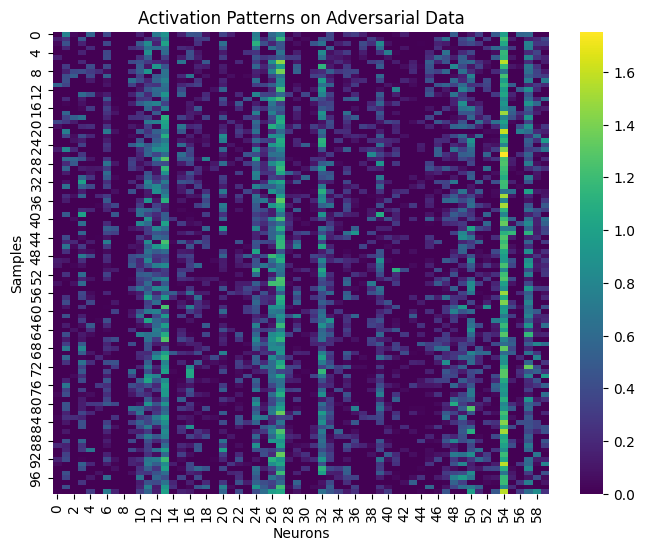

In [14]:
# Plotting weight histograms for different l1_lambda values
for l1_lambda in l1_lambda_list:
    config = Config(n_features=n_features, n_hidden=60, n_instances=1)
    model = Model(config=config, device=DEVICE, nonlinear_hidden=False, num_layers=1)
    optimize(model, steps=5000, lr=1e-3, l1_lambda=l1_lambda)
    plot_weight_histogram(model, title=f'Weight Histogram (l1_lambda={l1_lambda})')

# Analyze activation patterns on clean and adversarial data
config = Config(n_features=n_features, n_hidden=60, n_instances=1)
model = Model(config=config, device=DEVICE, nonlinear_hidden=False, num_layers=1)
optimize(model, steps=5000, lr=1e-3)
data_clean = model.generate_batch(n_batch=100)
data_adv = fgsm_attack(model, data_clean, epsilon=0.1, importance=model.importance)
plot_activation_patterns(model, data_clean, title='Activation Patterns on Clean Data')
plot_activation_patterns(model, data_adv, title='Activation Patterns on Adversarial Data')


In [15]:
# Experiment 2: Investigate Input Sparsity Levels
feature_probability_list = [0.3, 0.5, 0.7, 0.9]
results_sparsity = []
for feature_probability in feature_probability_list:
    results = run_experiment(
        n_features=n_features,
        n_hidden_list=n_hidden_list,
        l1_lambda_list=[0.0],
        l2_lambda_list=[0.0],
        attack_type='pgd',
        nonlinear_hidden=False,
        num_layers=1,
        feature_probability=feature_probability,
        correlated=False
    )
    results_sparsity.extend(results)

df_results_sparsity = pd.DataFrame(results_sparsity)

# Display the results
print("\nResults with Different Input Sparsity Levels:")
display(df_results_sparsity)


Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.102725
Step 500/5000, Loss: 0.059616
Step 1000/5000, Loss: 0.056745
Step 1500/5000, Loss: 0.053595
Step 2000/5000, Loss: 0.052796
Step 2500/5000, Loss: 0.052920
Step 3000/5000, Loss: 0.052123
Step 3500/5000, Loss: 0.052431
Step 4000/5000, Loss: 0.053028
Step 4500/5000, Loss: 0.053034
Step 4999/5000, Loss: 0.052121

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.110798
Step 500/5000, Loss: 0.036690
Step 1000/5000, Loss: 0.030818
Step 1500/5000, Loss: 0.027571
Step 2000/5000, Loss: 0.027846
Step 2500/5000, Loss: 0.026621
Step 3000/5000, Loss: 0.026533
Step 3500/5000, Loss: 0.026651
Step 4000/5000, Loss: 0.026663
Step 4500/5000, Loss: 0.027056
Step 4999/5000, Loss: 0.026702

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.111969
Step 500/5000, Loss: 0.019905
Step 1000/5000, Loss: 0.013547
Step 1500/5000, Loss: 0.011696
Step 2000/5000, Loss: 0.010870
Step 2500/5000, Loss: 0.011475
Step 3000/5000, Loss: 0.011382
Step 3500/5000, Loss: 0.011667
Step 4000/5000, Loss: 0.010901
Step 4500/5000, Loss: 0.011050
Step 4999/5000, Loss: 0.010963

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.108464
Step 500/5000, Loss: 0.008749
Step 1000/5000, Loss: 0.007703
Step 1500/5000, Loss: 0.007123
Step 2000/5000, Loss: 0.006432
Step 2500/5000, Loss: 0.006477
Step 3000/5000, Loss: 0.006748
Step 3500/5000, Loss: 0.006320
Step 4000/5000, Loss: 0.006424
Step 4500/5000, Loss: 0.006173
Step 4999/5000, Loss: 0.006084

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.114828
Step 500/5000, Loss: 0.000364
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000000
Step 4000/5000, Loss: 0.000001
Step 4500/5000, Loss: 0.000000
Step 4999/5000, Loss: 0.000000

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.119362
Step 500/5000, Loss: 0.000003
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000000
Step 4000/5000, Loss: 0.000000
Step 4500/5000, Loss: 0.000003
Step 4999/5000, Loss: 0.000004

Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.152507
Step 500/5000, Loss: 0.083084
Step 1000/5000, Loss: 0.083093
Step 1500/5000, Loss: 0.081788
Step 2000/5000, Loss: 0.080170
Step 2500/5000, Loss: 0.079222
Step 3000/5000, Loss: 0.078545
Step 3500/5000, Loss: 0.077001
Step 4000/5000, Loss: 0.078288
Step 4500/5000, Loss: 0.079015
Step 4999/5000, Loss: 0.077578

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.169598
Step 500/5000, Loss: 0.059370
Step 1000/5000, Loss: 0.059563
Step 1500/5000, Loss: 0.057353
Step 2000/5000, Loss: 0.054837
Step 2500/5000, Loss: 0.052953
Step 3000/5000, Loss: 0.051090
Step 3500/5000, Loss: 0.051140
Step 4000/5000, Loss: 0.051068
Step 4500/5000, Loss: 0.050958
Step 4999/5000, Loss: 0.050505

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.167684
Step 500/5000, Loss: 0.036555
Step 1000/5000, Loss: 0.036027
Step 1500/5000, Loss: 0.034669
Step 2000/5000, Loss: 0.031549
Step 2500/5000, Loss: 0.031231
Step 3000/5000, Loss: 0.030333
Step 3500/5000, Loss: 0.030683
Step 4000/5000, Loss: 0.029583
Step 4500/5000, Loss: 0.030024
Step 4999/5000, Loss: 0.029430

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.170947
Step 500/5000, Loss: 0.016491
Step 1000/5000, Loss: 0.015486
Step 1500/5000, Loss: 0.015895
Step 2000/5000, Loss: 0.015808
Step 2500/5000, Loss: 0.015751
Step 3000/5000, Loss: 0.015146
Step 3500/5000, Loss: 0.015209
Step 4000/5000, Loss: 0.015235
Step 4500/5000, Loss: 0.015098
Step 4999/5000, Loss: 0.014932

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.171996
Step 500/5000, Loss: 0.000033
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000001
Step 3500/5000, Loss: 0.000000
Step 4000/5000, Loss: 0.000000
Step 4500/5000, Loss: 0.000018
Step 4999/5000, Loss: 0.000000

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.162676
Step 500/5000, Loss: 0.000002
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000005
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000001
Step 4000/5000, Loss: 0.000000
Step 4500/5000, Loss: 0.000000
Step 4999/5000, Loss: 0.000000

Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.202640
Step 500/5000, Loss: 0.088834
Step 1000/5000, Loss: 0.088477
Step 1500/5000, Loss: 0.088377
Step 2000/5000, Loss: 0.088148
Step 2500/5000, Loss: 0.088177
Step 3000/5000, Loss: 0.087998
Step 3500/5000, Loss: 0.088025
Step 4000/5000, Loss: 0.088162
Step 4500/5000, Loss: 0.088433
Step 4999/5000, Loss: 0.088025

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.208659
Step 500/5000, Loss: 0.065916
Step 1000/5000, Loss: 0.065760
Step 1500/5000, Loss: 0.065710
Step 2000/5000, Loss: 0.065606
Step 2500/5000, Loss: 0.065882
Step 3000/5000, Loss: 0.065734
Step 3500/5000, Loss: 0.065441
Step 4000/5000, Loss: 0.065773
Step 4500/5000, Loss: 0.065218
Step 4999/5000, Loss: 0.065347

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.210870
Step 500/5000, Loss: 0.042864
Step 1000/5000, Loss: 0.042534
Step 1500/5000, Loss: 0.042240
Step 2000/5000, Loss: 0.042341
Step 2500/5000, Loss: 0.042851
Step 3000/5000, Loss: 0.042278
Step 3500/5000, Loss: 0.041924
Step 4000/5000, Loss: 0.042042
Step 4500/5000, Loss: 0.041941
Step 4999/5000, Loss: 0.041667

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.210961
Step 500/5000, Loss: 0.019751
Step 1000/5000, Loss: 0.019991
Step 1500/5000, Loss: 0.020056
Step 2000/5000, Loss: 0.020073
Step 2500/5000, Loss: 0.020301
Step 3000/5000, Loss: 0.020016
Step 3500/5000, Loss: 0.019769
Step 4000/5000, Loss: 0.019910
Step 4500/5000, Loss: 0.019619
Step 4999/5000, Loss: 0.020000

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.216004
Step 500/5000, Loss: 0.001001
Step 1000/5000, Loss: 0.000001
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000002
Step 3000/5000, Loss: 0.000001
Step 3500/5000, Loss: 0.000010
Step 4000/5000, Loss: 0.000006
Step 4500/5000, Loss: 0.000007
Step 4999/5000, Loss: 0.000004

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.222537
Step 500/5000, Loss: 0.000008
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000002
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000001
Step 3500/5000, Loss: 0.000013
Step 4000/5000, Loss: 0.000008
Step 4500/5000, Loss: 0.000002
Step 4999/5000, Loss: 0.000003

Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.242294
Step 500/5000, Loss: 0.088502
Step 1000/5000, Loss: 0.087934
Step 1500/5000, Loss: 0.086105
Step 2000/5000, Loss: 0.084067
Step 2500/5000, Loss: 0.083860
Step 3000/5000, Loss: 0.081287
Step 3500/5000, Loss: 0.082247
Step 4000/5000, Loss: 0.082423
Step 4500/5000, Loss: 0.079833
Step 4999/5000, Loss: 0.079756

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.238217
Step 500/5000, Loss: 0.058951
Step 1000/5000, Loss: 0.058598
Step 1500/5000, Loss: 0.058297
Step 2000/5000, Loss: 0.058495
Step 2500/5000, Loss: 0.058762
Step 3000/5000, Loss: 0.058619
Step 3500/5000, Loss: 0.058526
Step 4000/5000, Loss: 0.058082
Step 4500/5000, Loss: 0.058191
Step 4999/5000, Loss: 0.058560

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.254624
Step 500/5000, Loss: 0.039145
Step 1000/5000, Loss: 0.038778
Step 1500/5000, Loss: 0.038227
Step 2000/5000, Loss: 0.038144
Step 2500/5000, Loss: 0.038384
Step 3000/5000, Loss: 0.038758
Step 3500/5000, Loss: 0.038471
Step 4000/5000, Loss: 0.038683
Step 4500/5000, Loss: 0.038490
Step 4999/5000, Loss: 0.038136

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.264705
Step 500/5000, Loss: 0.019486
Step 1000/5000, Loss: 0.018729
Step 1500/5000, Loss: 0.019195
Step 2000/5000, Loss: 0.018921
Step 2500/5000, Loss: 0.018661
Step 3000/5000, Loss: 0.018975
Step 3500/5000, Loss: 0.019180
Step 4000/5000, Loss: 0.019016
Step 4500/5000, Loss: 0.018710
Step 4999/5000, Loss: 0.018993

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.263263
Step 500/5000, Loss: 0.002644
Step 1000/5000, Loss: 0.000005
Step 1500/5000, Loss: 0.000001
Step 2000/5000, Loss: 0.000001
Step 2500/5000, Loss: 0.000001
Step 3000/5000, Loss: 0.000022
Step 3500/5000, Loss: 0.000029
Step 4000/5000, Loss: 0.000004
Step 4500/5000, Loss: 0.000015
Step 4999/5000, Loss: 0.000002

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.251633
Step 500/5000, Loss: 0.000040
Step 1000/5000, Loss: 0.000004
Step 1500/5000, Loss: 0.000001
Step 2000/5000, Loss: 0.000001
Step 2500/5000, Loss: 0.000003
Step 3000/5000, Loss: 0.000001
Step 3500/5000, Loss: 0.000015
Step 4000/5000, Loss: 0.000016
Step 4500/5000, Loss: 0.000004
Step 4999/5000, Loss: 0.000004

Results with Different Input Sparsity Levels:


,n_hidden,l1_lambda,l2_lambda,loss_clean,loss_adv,superposition,attack_type,nonlinear_hidden,num_layers,feature_probability,correlated
0,20,0.0,0.0,5.210820e-02,0.057727,0.005098,pgd,False,1,0.3,False
1,40,0.0,0.0,2.696284e-02,0.036682,0.010827,pgd,False,1,0.3,False
2,60,0.0,0.0,1.108534e-02,0.021532,0.018859,pgd,False,1,0.3,False
3,80,0.0,0.0,6.519396e-03,0.016434,0.033851,pgd,False,1,0.3,False
4,100,0.0,0.0,4.229447e-07,0.009504,0.049226,pgd,False,1,0.3,False
5,120,0.0,0.0,4.304617e-06,0.009279,0.054571,pgd,False,1,0.3,False
6,20,0.0,0.0,7.771384e-02,0.087723,0.006915,pgd,False,1,0.5,False
7,40,0.0,0.0,4.979945e-02,0.065405,0.013512,pgd,False,1,0.5,False
8,60,0.0,0.0,3.001935e-02,0.046816,0.022354,pgd,False,1,0.5,False
9,80,0.0,0.0,1.530133e-02,0.028633,0.040047,pgd,False,1,0.5,False


In [16]:
# Experiment 3: Introduce Correlated Features
correlation_coefficients = [0.2, 0.5, 0.8]
results_correlation = []
for corr_coef in correlation_coefficients:
    corr_matrix = create_correlation_matrix(n_features, corr_coef)
    results = run_experiment(
        n_features=n_features,
        n_hidden_list=n_hidden_list,
        l1_lambda_list=[0.0],
        l2_lambda_list=[0.0],
        attack_type='pgd',
        nonlinear_hidden=False,
        num_layers=1,
        feature_probability=0.5,
        correlated=True,
        correlation_matrix=corr_matrix
    )
    results_correlation.extend(results)

df_results_correlation = pd.DataFrame(results_correlation)

# Display the results
print("\nResults with Correlated Features:")
display(df_results_correlation)


Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.159762
Step 500/5000, Loss: 0.082796
Step 1000/5000, Loss: 0.082755
Step 1500/5000, Loss: 0.082084
Step 2000/5000, Loss: 0.080520
Step 2500/5000, Loss: 0.079445
Step 3000/5000, Loss: 0.079242
Step 3500/5000, Loss: 0.078434
Step 4000/5000, Loss: 0.078400
Step 4500/5000, Loss: 0.078712
Step 4999/5000, Loss: 0.077592

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.160692
Step 500/5000, Loss: 0.059743
Step 1000/5000, Loss: 0.059015
Step 1500/5000, Loss: 0.058006
Step 2000/5000, Loss: 0.055045
Step 2500/5000, Loss: 0.053224
Step 3000/5000, Loss: 0.051931
Step 3500/5000, Loss: 0.050916
Step 4000/5000, Loss: 0.050482
Step 4500/5000, Loss: 0.050710
Step 4999/5000, Loss: 0.050976

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.167659
Step 500/5000, Loss: 0.036267
Step 1000/5000, Loss: 0.035952
Step 1500/5000, Loss: 0.033350
Step 2000/5000, Loss: 0.031162
Step 2500/5000, Loss: 0.030343
Step 3000/5000, Loss: 0.029981
Step 3500/5000, Loss: 0.030190
Step 4000/5000, Loss: 0.029607
Step 4500/5000, Loss: 0.030667
Step 4999/5000, Loss: 0.029773

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.167034
Step 500/5000, Loss: 0.015781
Step 1000/5000, Loss: 0.016153
Step 1500/5000, Loss: 0.016109
Step 2000/5000, Loss: 0.015680
Step 2500/5000, Loss: 0.015298
Step 3000/5000, Loss: 0.015240
Step 3500/5000, Loss: 0.014976
Step 4000/5000, Loss: 0.014803
Step 4500/5000, Loss: 0.015177
Step 4999/5000, Loss: 0.015297

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.163811
Step 500/5000, Loss: 0.000017
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000010
Step 3000/5000, Loss: 0.000002
Step 3500/5000, Loss: 0.000000
Step 4000/5000, Loss: 0.000002
Step 4500/5000, Loss: 0.000006
Step 4999/5000, Loss: 0.000005

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.173794
Step 500/5000, Loss: 0.000004
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000001
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000001
Step 4000/5000, Loss: 0.000000
Step 4500/5000, Loss: 0.000004
Step 4999/5000, Loss: 0.000001

Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.154601
Step 500/5000, Loss: 0.082976
Step 1000/5000, Loss: 0.082372
Step 1500/5000, Loss: 0.081042
Step 2000/5000, Loss: 0.080646
Step 2500/5000, Loss: 0.077831
Step 3000/5000, Loss: 0.078136
Step 3500/5000, Loss: 0.078442
Step 4000/5000, Loss: 0.078086
Step 4500/5000, Loss: 0.078118
Step 4999/5000, Loss: 0.077953

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.162154
Step 500/5000, Loss: 0.059699
Step 1000/5000, Loss: 0.058861
Step 1500/5000, Loss: 0.057360
Step 2000/5000, Loss: 0.053956
Step 2500/5000, Loss: 0.053076
Step 3000/5000, Loss: 0.051897
Step 3500/5000, Loss: 0.051235
Step 4000/5000, Loss: 0.050653
Step 4500/5000, Loss: 0.050859
Step 4999/5000, Loss: 0.050299

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.163015
Step 500/5000, Loss: 0.036303
Step 1000/5000, Loss: 0.035773
Step 1500/5000, Loss: 0.033692
Step 2000/5000, Loss: 0.031571
Step 2500/5000, Loss: 0.030702
Step 3000/5000, Loss: 0.029983
Step 3500/5000, Loss: 0.029712
Step 4000/5000, Loss: 0.029566
Step 4500/5000, Loss: 0.029276
Step 4999/5000, Loss: 0.029266

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.164968
Step 500/5000, Loss: 0.016186
Step 1000/5000, Loss: 0.015841
Step 1500/5000, Loss: 0.015660
Step 2000/5000, Loss: 0.015688
Step 2500/5000, Loss: 0.015388
Step 3000/5000, Loss: 0.015114
Step 3500/5000, Loss: 0.015094
Step 4000/5000, Loss: 0.015210
Step 4500/5000, Loss: 0.014841
Step 4999/5000, Loss: 0.015087

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.175732
Step 500/5000, Loss: 0.000683
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000002
Step 3500/5000, Loss: 0.000009
Step 4000/5000, Loss: 0.000000
Step 4500/5000, Loss: 0.000000
Step 4999/5000, Loss: 0.000007

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.174744
Step 500/5000, Loss: 0.000004
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000018
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000001
Step 4000/5000, Loss: 0.000011
Step 4500/5000, Loss: 0.000000
Step 4999/5000, Loss: 0.000001

Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.158307
Step 500/5000, Loss: 0.083214
Step 1000/5000, Loss: 0.082740
Step 1500/5000, Loss: 0.081394
Step 2000/5000, Loss: 0.080689
Step 2500/5000, Loss: 0.078333
Step 3000/5000, Loss: 0.078393
Step 3500/5000, Loss: 0.078208
Step 4000/5000, Loss: 0.077885
Step 4500/5000, Loss: 0.077519
Step 4999/5000, Loss: 0.077700

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.165864
Step 500/5000, Loss: 0.059536
Step 1000/5000, Loss: 0.059763
Step 1500/5000, Loss: 0.058250
Step 2000/5000, Loss: 0.056077
Step 2500/5000, Loss: 0.053023
Step 3000/5000, Loss: 0.052700
Step 3500/5000, Loss: 0.051417
Step 4000/5000, Loss: 0.051189
Step 4500/5000, Loss: 0.051049
Step 4999/5000, Loss: 0.050612

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.166627
Step 500/5000, Loss: 0.036633
Step 1000/5000, Loss: 0.035445
Step 1500/5000, Loss: 0.033958
Step 2000/5000, Loss: 0.030871
Step 2500/5000, Loss: 0.030687
Step 3000/5000, Loss: 0.029938
Step 3500/5000, Loss: 0.030680
Step 4000/5000, Loss: 0.030108
Step 4500/5000, Loss: 0.029697
Step 4999/5000, Loss: 0.030129

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.163848
Step 500/5000, Loss: 0.015885
Step 1000/5000, Loss: 0.015700
Step 1500/5000, Loss: 0.015789
Step 2000/5000, Loss: 0.015733
Step 2500/5000, Loss: 0.015378
Step 3000/5000, Loss: 0.015424
Step 3500/5000, Loss: 0.015071
Step 4000/5000, Loss: 0.015152
Step 4500/5000, Loss: 0.015104
Step 4999/5000, Loss: 0.015011

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.166975
Step 500/5000, Loss: 0.000193
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000000
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000000
Step 4000/5000, Loss: 0.000001
Step 4500/5000, Loss: 0.000003
Step 4999/5000, Loss: 0.000003

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.174625
Step 500/5000, Loss: 0.000003
Step 1000/5000, Loss: 0.000000
Step 1500/5000, Loss: 0.000000
Step 2000/5000, Loss: 0.000000
Step 2500/5000, Loss: 0.000010
Step 3000/5000, Loss: 0.000000
Step 3500/5000, Loss: 0.000000
Step 4000/5000, Loss: 0.000000
Step 4500/5000, Loss: 0.000000
Step 4999/5000, Loss: 0.000001

Results with Correlated Features:


,n_hidden,l1_lambda,l2_lambda,loss_clean,loss_adv,superposition,attack_type,nonlinear_hidden,num_layers,feature_probability,correlated
0,20,0.0,0.0,6.484666e-02,0.074891,0.006135,pgd,False,1,0.5,True
1,40,0.0,0.0,4.894282e-02,0.061660,0.013256,pgd,False,1,0.5,True
2,60,0.0,0.0,3.115552e-02,0.046496,0.023863,pgd,False,1,0.5,True
3,80,0.0,0.0,1.465399e-02,0.028261,0.039867,pgd,False,1,0.5,True
4,100,0.0,0.0,6.674555e-06,0.010070,0.050028,pgd,False,1,0.5,True
5,120,0.0,0.0,1.178775e-06,0.009789,0.055990,pgd,False,1,0.5,True
6,20,0.0,0.0,6.445748e-02,0.076255,0.006300,pgd,False,1,0.5,True
7,40,0.0,0.0,5.032574e-02,0.065814,0.012458,pgd,False,1,0.5,True
8,60,0.0,0.0,3.528979e-02,0.048117,0.023090,pgd,False,1,0.5,True
9,80,0.0,0.0,1.652046e-02,0.030085,0.040193,pgd,False,1,0.5,True


In [18]:
# Experiment 4: Extend to Different Architectures
# Nonlinear hidden layers and deeper networks
results_architecture = run_experiment(
    n_features=n_features,
    n_hidden_list=n_hidden_list,
    l1_lambda_list=[0.0],
    l2_lambda_list=[0.0],
    attack_type='pgd',
    nonlinear_hidden=True,
    num_layers=3,  # Deeper network
    feature_probability=0.5,
    correlated=False
)

df_results_architecture = pd.DataFrame(results_architecture)

# Display the results
print("\nResults with Nonlinear Hidden Layers and Deeper Networks:")
display(df_results_architecture)


Training model with n_hidden = 20, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.149044
Step 500/5000, Loss: 0.096010
Step 1000/5000, Loss: 0.095828
Step 1500/5000, Loss: 0.096170
Step 2000/5000, Loss: 0.095805
Step 2500/5000, Loss: 0.095614
Step 3000/5000, Loss: 0.095172
Step 3500/5000, Loss: 0.093470
Step 4000/5000, Loss: 0.093101
Step 4500/5000, Loss: 0.092443
Step 4999/5000, Loss: 0.092937

Training model with n_hidden = 40, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.148547
Step 500/5000, Loss: 0.079529
Step 1000/5000, Loss: 0.079977
Step 1500/5000, Loss: 0.079085
Step 2000/5000, Loss: 0.078478
Step 2500/5000, Loss: 0.078486
Step 3000/5000, Loss: 0.077757
Step 3500/5000, Loss: 0.077070
Step 4000/5000, Loss: 0.076169
Step 4500/5000, Loss: 0.076151
Step 4999/5000, Loss: 0.076254

Training model with n_hidden = 60, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.149297
Step 500/5000, Loss: 0.059526
Step 1000/5000, Loss: 0.056358
Step 1500/5000, Loss: 0.054304
Step 2000/5000, Loss: 0.054846
Step 2500/5000, Loss: 0.054067
Step 3000/5000, Loss: 0.052613
Step 3500/5000, Loss: 0.051754
Step 4000/5000, Loss: 0.049736
Step 4500/5000, Loss: 0.049843
Step 4999/5000, Loss: 0.048287

Training model with n_hidden = 80, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.144824
Step 500/5000, Loss: 0.043769
Step 1000/5000, Loss: 0.039634
Step 1500/5000, Loss: 0.039963
Step 2000/5000, Loss: 0.039163
Step 2500/5000, Loss: 0.039045
Step 3000/5000, Loss: 0.038920
Step 3500/5000, Loss: 0.037328
Step 4000/5000, Loss: 0.037157
Step 4500/5000, Loss: 0.036533
Step 4999/5000, Loss: 0.036818

Training model with n_hidden = 100, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.145531
Step 500/5000, Loss: 0.029217
Step 1000/5000, Loss: 0.024734
Step 1500/5000, Loss: 0.023198
Step 2000/5000, Loss: 0.021924
Step 2500/5000, Loss: 0.021630
Step 3000/5000, Loss: 0.021965
Step 3500/5000, Loss: 0.021093
Step 4000/5000, Loss: 0.021036
Step 4500/5000, Loss: 0.021484
Step 4999/5000, Loss: 0.020976

Training model with n_hidden = 120, l1_lambda = 0.0, l2_lambda = 0.0


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0/5000, Loss: 0.151024
Step 500/5000, Loss: 0.018004
Step 1000/5000, Loss: 0.012640
Step 1500/5000, Loss: 0.010757
Step 2000/5000, Loss: 0.009592
Step 2500/5000, Loss: 0.009312
Step 3000/5000, Loss: 0.007849
Step 3500/5000, Loss: 0.007744
Step 4000/5000, Loss: 0.007859
Step 4500/5000, Loss: 0.008087
Step 4999/5000, Loss: 0.007900

Results with Nonlinear Hidden Layers and Deeper Networks:


,n_hidden,l1_lambda,l2_lambda,loss_clean,loss_adv,superposition,attack_type,nonlinear_hidden,num_layers,feature_probability,correlated
0,20,0.0,0.0,0.092449,0.100393,0.038359,pgd,True,3,0.5,False
1,40,0.0,0.0,0.075062,0.086453,0.064516,pgd,True,3,0.5,False
2,60,0.0,0.0,0.048271,0.064447,0.088073,pgd,True,3,0.5,False
3,80,0.0,0.0,0.036868,0.051326,0.105941,pgd,True,3,0.5,False
4,100,0.0,0.0,0.020727,0.035135,0.136126,pgd,True,3,0.5,False
5,120,0.0,0.0,0.007772,0.016613,0.146106,pgd,True,3,0.5,False
